# DIEGO SANZ VILLAFRUELA

## Exercise 4: water permeability prediction in forestry

In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing
import operator
import matplotlib.pyplot as plt
import heapq
from threading import Thread

%matplotlib inline

In [2]:
"""
Performance measure that indicates how well the model captures the relative ordering/ranking
of the data points.
C-index is measured from 0 to 1, with 0.5 meaning the model wasn't able to capture any information
from the data.
"""
def getCIndex(labels, predictions):
    if labels is None or predictions is None:
        raise Exception("Illegal argument exception")
    if len(labels) != len(predictions):
        raise Exception("The number of labels is not the same to the number of predictions")
        
    size = len(labels)
    h_num = 0
    n = 0
    for i in range(size):
        li = labels[i]
        pi = predictions[i]
        for j in range(i+1,size):
            lj = labels[j]
            pj = predictions[j]
            if ( li != lj):
                n += 1
                if (pi < pj and li < lj) or (pi > pj and li > lj):
                    h_num += 1
                elif pi == pj:
                    h_num += 0.5 # -1 0.5 1
    return h_num/n


In [3]:
# STANDARIZATION OF THE INPUT DATA
def standarize_feature(feature_column):
    mean_value = feature_column.mean()
    standard_deviation = feature_column.std();
    
    for element_index in range(len(feature_column)):
        feature_column[element_index] = (feature_column[element_index] - mean_value) / standard_deviation

def standarize_features(input_data):
    input_data_copy = input_data.copy()
    
    feature_number = len(input_data_copy[0])
    
    for feature_index in range (feature_number):
        standarize_feature(input_data_copy[:,feature_index])
    
    return input_data_copy

def sklearn_standarize_features(input_data):
    input_data_copy = np.zeros(input_data.shape)

    feature_number = len(input_data[0])
    
    for feature_index in range (feature_number):
        input_data_copy[:,feature_index] = preprocessing.scale(input_data[:,feature_index])
    
    return input_data_copy

In [4]:
"""
Calculates the Ecludean distance between 2 samples. 
It is mainly used when data is continuous.
Note:
Discrete data can only take particular values whereas Continuous data are not restricted
to defined separate values, but can occupy any value over a continuous range.
"""
def euclideanDistance(instance1, instance2, origin, end):
    distance = 0
    for propertyIndex in range(origin, end):
        distance += pow((instance1[propertyIndex] - instance2[propertyIndex]), 2)
    return math.sqrt(distance)

"""
Gets the k closest neighbors from the trainingSet. 
"""
def getNeighbors(trainingSet, testInstance, k, dead_radius, origin_property, end_property):
    distances = []
    
    for train_element in trainingSet:
        euclidean_dist = euclideanDistance(testInstance, train_element, origin_property, end_property)
        distances.append((euclidean_dist, train_element))
           
    distances.sort(key=operator.itemgetter(0))
   
    best_neighbors = []
    n = min(k, len(distances))
    for i in range(n):
        best_neighbors.append(distances[i][1])
    
    return best_neighbors

def getResponse(neighbors):
    length = len(neighbors)
    if length == 0:
        raise ValueError("The number of elements is 0")
    
    prediction = 0
    for neighbor in neighbors:
        prediction += neighbor[-1]
    
    return prediction / len(neighbors)
    
    
"""
Calculates the accuracy of a kNearestNeighbors classifier.
"""
def kNearestNeighbors(trainingData, testData, **kwargs):
    k = kwargs.get("k")
    dead_radius = kwargs.get("radius")
    origin_property = kwargs.get("origin_property")
    end_property = kwargs.get("end_property")
    
    if k is None:
        k = 1
    if dead_radius is None:
        raise ValueError("Illegal arguments")
    
    if origin_property is None or end_property is None:
        raise ValueError("You didn't specify the input properties")
        
    if k > len(trainingData):
        raise ValueError("Elements are less than k: {}".format(k))
    
    if testData.ndim != 2:
        raise ValueError("TesData must have dimension 2 and not {}".format(testData.ndim))

    if trainingData.ndim != 2:
        raise ValueError("TrainingData must have dimension 2 and not {}".format(trainingData.ndim))

    predictions = []
    
    for testInstance in testData:
    
        neighbors = getNeighbors(trainingData, testInstance, k, dead_radius, origin_property, end_property)
        
        prediction = getResponse(neighbors)
        
        predictions.append(prediction)
        
    return predictions

In [5]:

def get_elements_out_dead_zone(elements, ref_element, end_property):
    out_elements = []
    
    test_x = ref_element[end_property]
    test_y = ref_element[end_property + 1]
        
    for element in elements:
        train_x = element[end_property]
        train_y = element[end_property + 1]

        distance = math.sqrt(pow(train_x - test_x, 2) + pow(train_y - test_y, 2))
        #print("test: ({} , {}), train({} , {}) = {}".format(test_x, test_y, train_x, train_y, distance))
        if distance > dead_radius:
            out_elements.append(element)
            
    return out_elements

def leave_one_out_cv(samples, end, predictionMethod, **kwargs):
    n = len(samples[0])
    all_predictions = []
    all_labels = []
    
    for fold in range(0,len(samples)):
        testData =  samples[fold]
        
        # elements outside the dead zone
        trainingData = get_elements_out_dead_zone(samples[:fold], testData, end) \
                    + get_elements_out_dead_zone(samples[fold+1:], testData, end)
        trainingData = np.array(trainingData)
        # testada must have dimension 2 before being pass to knn
        testData = testData.reshape((1,n))
                    
        # predictions
        predictions = predictionMethod(trainingData, testData, **kwargs)
        labels = [testInstance[-1] for testInstance in testData]
        
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        #print("Fold:{}, k:{} , len(trainingData:{} , dead_radius:{}".format(fold, k, len(trainingData), dead_radius))
        
    return getCIndex(all_labels, all_predictions)

In [6]:
# READING THE DATA
INPUT_DATA = np.genfromtxt('INPUT.csv', delimiter=',')
COORDINATES = np.genfromtxt('COORDINATES.csv', delimiter=',')
OUTPUT_DATA = np.genfromtxt('OUTPUT.csv', delimiter='')
OUTPUT_DATA = OUTPUT_DATA.reshape((len(OUTPUT_DATA), 1))

STANDARDIZED_INPUT_DATA = sklearn_standarize_features(INPUT_DATA)

ALL_DATA = np.concatenate((STANDARDIZED_INPUT_DATA, COORDINATES, OUTPUT_DATA), axis=1)

print(ALL_DATA.shape)

# print("testData: ", test_data.shape)
# print("from 0 to {}".format(len(INPUT_DATA[0])))

# spacial_kNearestNeighbors(train_data, test_data, k=1, radius= 2, origin_property=0, end_property=len(INPUT_DATA[0]))

print("start")
performance = {}

for dead_radius in range(0,210,10):
    for k in [1, 3, 5, 7, 9]:
        c_index = leave_one_out_cv(ALL_DATA, len(INPUT_DATA[0]), kNearestNeighbors, k=k, radius= dead_radius, origin_property=0, end_property=len(INPUT_DATA[0]))
        performance[dead_radius, k] = c_index
        print("dead_radius: {}, k: {}".format(dead_radius, k))
print("end")

print(performance)

(1691, 98)
start
dead_radius: 0, k: 1
dead_radius: 0, k: 3
dead_radius: 0, k: 5
dead_radius: 0, k: 7
dead_radius: 0, k: 9
dead_radius: 10, k: 1
dead_radius: 10, k: 3
dead_radius: 10, k: 5
dead_radius: 10, k: 7
dead_radius: 10, k: 9
dead_radius: 20, k: 1
dead_radius: 20, k: 3
dead_radius: 20, k: 5
dead_radius: 20, k: 7
dead_radius: 20, k: 9
dead_radius: 30, k: 1
dead_radius: 30, k: 3
dead_radius: 30, k: 5
dead_radius: 30, k: 7
dead_radius: 30, k: 9
dead_radius: 40, k: 1
dead_radius: 40, k: 3
dead_radius: 40, k: 5
dead_radius: 40, k: 7
dead_radius: 40, k: 9
dead_radius: 50, k: 1
dead_radius: 50, k: 3
dead_radius: 50, k: 5
dead_radius: 50, k: 7
dead_radius: 50, k: 9
dead_radius: 60, k: 1
dead_radius: 60, k: 3
dead_radius: 60, k: 5
dead_radius: 60, k: 7
dead_radius: 60, k: 9
dead_radius: 70, k: 1
dead_radius: 70, k: 3
dead_radius: 70, k: 5
dead_radius: 70, k: 7
dead_radius: 70, k: 9
dead_radius: 80, k: 1
dead_radius: 80, k: 3
dead_radius: 80, k: 5
dead_radius: 80, k: 7
dead_radius: 80, k: 

{0: 0.7209388111080468, 10: 0.711604526765678, 20: 0.7115709288017146, 30: 0.7053395564228808, 40: 0.7043060690522155, 50: 0.7008269298880487, 60: 0.6992576249879258, 70: 0.6943603717614713, 80: 0.6909792266588645, 90: 0.688658517293852, 100: 0.6868911243978615, 110: 0.6546552778901599, 120: 0.6340313776985115, 130: 0.6214027429937746, 140: 0.6192727720700125, 150: 0.6163200010079389, 160: 0.6171805988557093, 170: 0.6169202146349931, 180: 0.6161597107215303, 190: 0.6158636286641029, 200: 0.6147272475287997}


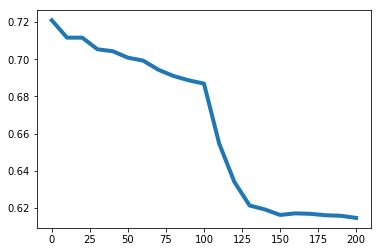

In [9]:
# showing the greatest c-indexes

plotData = performance.copy()

bestCIndex = {}
for key, value in plotData.items():
    dead_radius = key[0]
    k = key[1]

    bestCIndex[dead_radius] = max(bestCIndex.get(dead_radius,0), value);


print(bestCIndex)

plt.plot(list(bestCIndex.keys()), list(bestCIndex.values()), linewidth=4.0)

plt.show()


# Results

The model is more optimistic when there is not any spatial distance(dead area) between the samples.
When the distance is 100 meters, it seems that the model is slightly more realistic taking into account the spatial correlation of the data.

After 100 meters, the model starts having some problems predicting. So a radius of 100 meters would be a good metric for our model.

The c-index is not very high. The most likely reason that explains these bad results is the number of features. The training data in the model has too many features and some of them could not have any relevance to make prediction.
